In [1]:
import seml
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def load_exp():
    results = seml.get_results('review_overrobust_evaluate', to_data_frame=False)
    dfs = []
    for x in results:
        df = pd.DataFrame(x['result']['result_df'].copy())
        df.loc[:,'model'] = x['config']['model_label']
        df.loc[:,'dataset'] = x['config']['dataset']
        df.loc[:,'seed'] = x['config']['seed']
        df.loc[:,'projection'] = x['config']['projection']
        #df.loc[:,'do_lp'] = x['config']['do_lp']
        df.loc[:,'lp_alpha'] = x['config']['lp_params']['alpha']
        df.loc[:,'lp_num_layers'] = x['config']['lp_params']['num_layers']
        df.loc[:,'model_accuracy'] = x['result']['model_accuracy']
        df.loc[:,'dense_split'] = x['config']['dense_split']
        df.loc[:,'n_per_class'] = str(x['config']['n_per_class'])
        dfs.append(df)
    df = pd.concat(dfs)
    return df.rename(columns = {'json://1': '1', 'json://2': '2', 'json://3': '3', 'json://4': '4', 'json://5': '5', 'json://6': '6', 'json://0': '0'})
    

In [3]:
df = load_exp()

In [ ]:
def compute_min_max_cols(df, clip = None):
    if not clip is None:
        df[[str(x) for x in range(40) if str(x) in df.columns]] = df[[str(x) for x in range(40) if str(x) in df.columns]].clip(upper=clip)
    df['max'] = df[[str(x) for x in range(40) if str(x) in df.columns]].max(axis=1)
    df['min'] = df[[str(x) for x in range(40) if str(x) in df.columns]].min(axis=1)
    return df

In [ ]:
from cProfile import label
from matplotlib.ft2font import LOAD_IGNORE_GLOBAL_ADVANCE_WIDTH
from scipy import stats

def filter_df(df, filter_dict):
    df_copy=df.copy()
    for k, v in filter_dict.items():
        df_copy = df_copy[df_copy[k]==v]
    return df_copy


def get_style(label: str):
    color_dict = {
            "MLP": 'r',
            "GCN": 'tab:green', 
            "APPNP": 'lime', 
            "SGC": "b",
            "GAT": "slategrey",
            "GATv2": "k",
            "GraphSAGE": "lightsteelblue",
            "LP": "wheat"
        }
    linestyle_dict = {
            "LP": '--'
        }
    use_color=""
    linestyle="-"
    for key, color in color_dict.items():
        sep_labels = label.split("+")
        if sep_labels[0] == key:
            use_color = color
            if len(sep_labels) == 2 or sep_labels[0] == "LP":
                linestyle = "--"
    return use_color, linestyle

def compute_means_per_degree(df, filter_dict, type='min', max_degree=10):
    # filter model
    df = filter_df(df, filter_dict)
    # get means per degree
    degrees = np.sort(df[df['degree']<=max_degree]['degree'].unique())
    values = []
    deviations = []
    for deg in degrees:
        degree_df = df[df['degree']==deg]
        means = []
        seeds = degree_df['seed'].unique()
        for seed in seeds:
            if type=='all':
                means.append(degree_df[degree_df['seed']==seed][['0','1','2','3','4','5','6']].mean().mean())
            else:
                means.append(degree_df[degree_df['seed']==seed][type].mean())
        deviations.append(stats.sem(means))
        values.append(np.mean(means))
    return degrees, values, deviations

def plot_1(df, type='min', models=['GCN', 'APPNP', 'GCN+LP', 'APPNP+LP'], max_degree=10, plot_lp_alphas=[0.7], filter_dict={}, clip=None):
    df = filter_df(df, filter_dict)
    df = compute_min_max_cols(df, clip)
    fig, axs = plt.subplots(figsize=(4*1.62, 4))
    for model in models:
        filter_dict['model']= model
        color, linestyle = get_style(model)
        if 'LP' in model:
            for alpha in plot_lp_alphas:
                filter_dict['lp_alpha'] = alpha
                model_label = f'{model} ($\\alpha={alpha}$)'
                degrees, values, deviations = compute_means_per_degree(df, filter_dict, type=type, max_degree=max_degree)
                plt.errorbar(x=degrees, y=values, yerr=deviations, label=model_label, capsize=5, color=color, linestyle=linestyle, linewidth=2.5, marker="o",markersize=8)
        else:
            degrees, values, deviations = compute_means_per_degree(df, filter_dict, type=type, max_degree=max_degree)
            plt.errorbar(x=degrees, y=values, yerr=deviations, label=model, capsize=5, color=color, linestyle=linestyle, linewidth=2.5, marker="o",markersize=8)
    plt.xticks([x+1 for x in range(max_degree)])
    plt.legend(fontsize=14)
    #plt.title(f'Average Robustness to Structure Changes per Node Degree')
    plt.xlabel('Node degree', fontsize=14)
    plt.ylabel('$\max_{c\\neq c*}$ $N_c(v)$', fontsize = 14)
    #plt.ylabel('Number of Structure Changes', fontsize=12)
    plt.grid()

    #plt.xlabel('Node degree', fontsize = 15)

    return fig


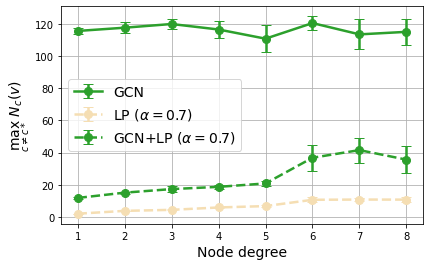

In [ ]:
fig = plot_1(df, 
            type='max', 
            models=['GCN', 'LP', 'GCN+LP'], 
            max_degree=8, 
            filter_dict={'dataset': 'pubmed', 'dense_split': True, 'projection': True}, 
            plot_lp_alphas=[0.7])

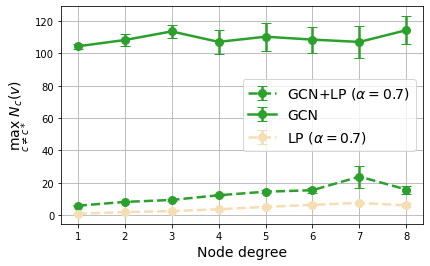

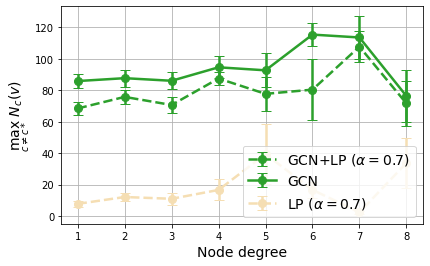

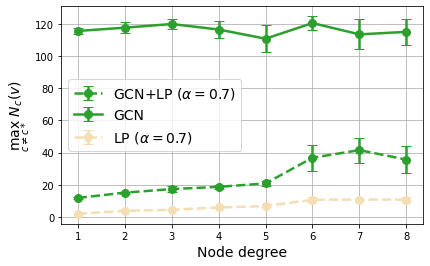

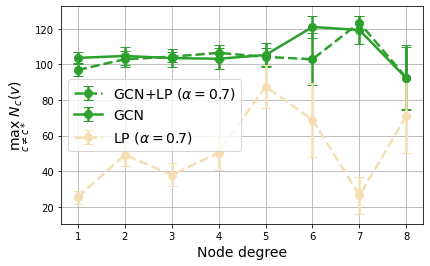

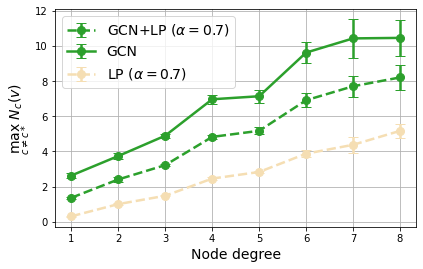

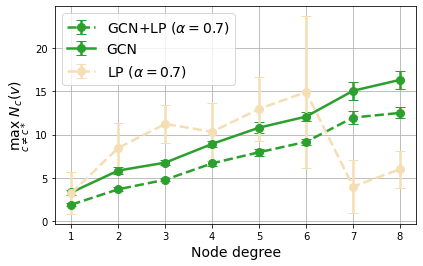

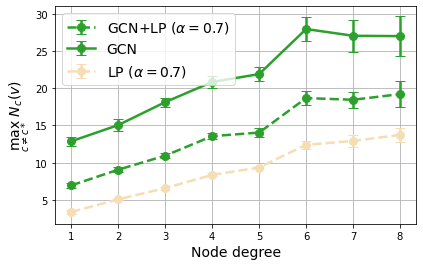

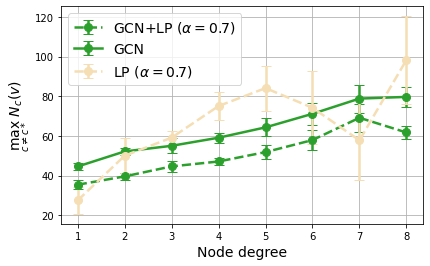

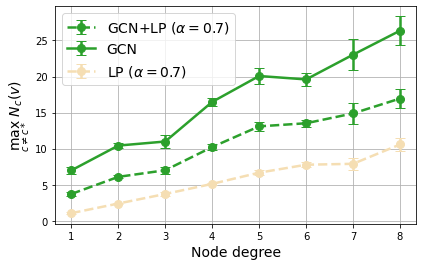

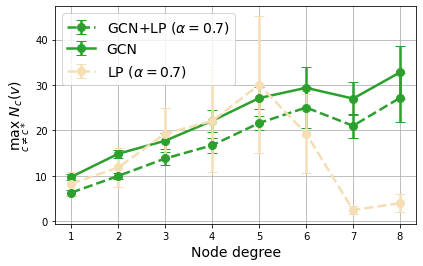

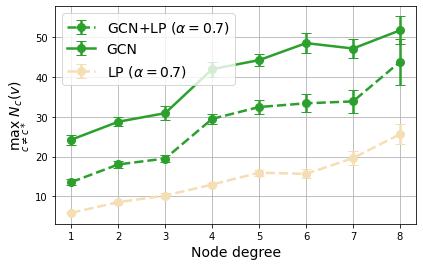

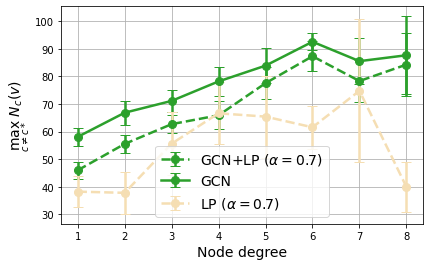

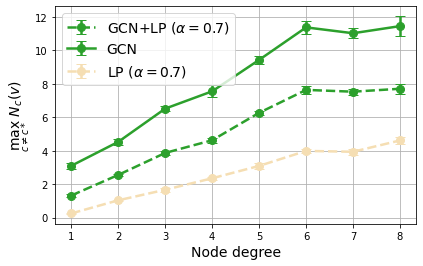

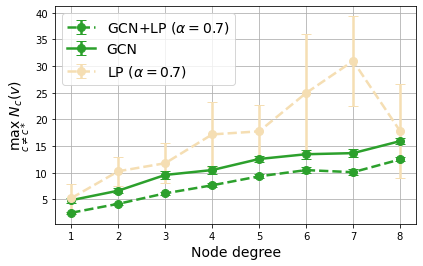

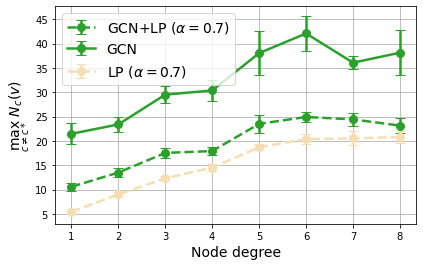

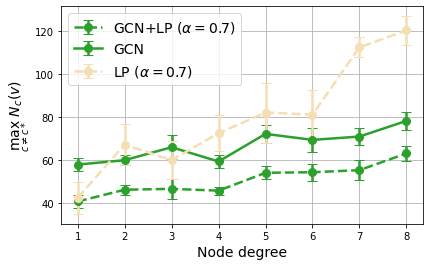

In [ ]:
datasets = ['pubmed', 'Cora', 'citeseer', 'cora_ml']
types = ['min', 'max']
models=['GCN+LP', 'GCN', 'LP']
filter_dict_add = {'projection': True}#filter_dict_from_name(model)

for dataset in datasets:
    for type in types:
        for split, split_name in [(True, 'dense_split'), (False, 'sparse_split')]:
            filter_dict = filter_dict_add.copy()
            filter_dict.update({'dense_split': split, 'dataset':dataset})
            fig = plot_1(df, type=type, models=models, max_degree=8, filter_dict=filter_dict)
            fig.savefig(f'plots/{split_name}/{dataset}/sem_{type}.pdf', bbox_inches='tight', format='pdf')

In [ ]:
def get_model_acc(df):
    #df_1 = df[df['dataset']==dataset]
    # plot original acc
    df_1 = df[['seed', 'model', 'lp_alpha', 'lp_num_layers', 'dataset', 'model_accuracy', 'dense_split']].drop_duplicates()
    df_1=df_1.set_index(np.array(range(len(df_1))))
    #df_1 = df_1[df_1['dataset']=='cora_ml']
    #df_1 = df_1.drop(df_1[(df_1['model']=='LP')&((df_1['do_lp']==False))].index)
    #df_1 = df_1.drop(df_1[(df_1['model']=='GCN')&((df_1['do_lp']==False))&((df_1['lp_alpha']!=0.3))].index)
    res = df_1 .groupby(['dataset', 'dense_split','model', 'lp_alpha', 'lp_num_layers']).mean()[['model_accuracy']]
    res['acc std'] = df_1 .groupby(['dataset', 'dense_split','model', 'lp_alpha', 'lp_num_layers']).std()[['model_accuracy']]
    return res


df_1 = get_model_acc(df)
# df_2 = get_model_acc(df, 'pubmed')
# df = df_1.append(df_2)
# df = df.reset_index()
# df['accuracy_1'] = (df['model_accuracy']*100).astype(str).str[:4] +' \pm '+ (df['acc std']*100).astype(str).str[:4]
df_1

model_accuracy   acc std
dataset  dense_split model  lp_alpha lp_num_layers                          
Cora     False       GCN    0.7      10                   0.823661  0.014278
                     GCN+LP 0.7      10                   0.830357  0.017181
                     LP     0.7      10                   0.130714  0.022788
         True        GCN    0.7      10                   0.876339  0.020287
                     GCN+LP 0.7      10                   0.878125  0.017748
                     LP     0.7      10                   0.854911  0.018795
citeseer False       GCN    0.7      10                   0.665104  0.024187
                     GCN+LP 0.7      10                   0.665625  0.021565
                     LP     0.7      10                   0.158333  0.029714
         True        GCN    0.7      10                   0.694271  0.017528
                     GCN+LP 0.7      10                   0.695313  0.016281
                     LP     0.7      10                   0.665104  0.021239
cora_ml  False       GCN    0.7      10                   0.835268  0.017953
                     GCN+LP 0.7      10                   0.840179  0.027845
                     LP     0.7      10                   0.151339  0.049998
         True        GCN    0.7      10                   0.871429  0.020293
                     GCN+LP 0.7      10                   0.867411  0.017851
                     LP     0.7      10                   0.840625  0.024517
pubmed   False       GCN    0.7      10                   0.767708  0.022903
                     GCN+LP 0.7      10                   0.769792  0.029188
                     LP     0.7      10                   0.375926  0.088530
         True        GCN    0.7      10                   0.853125  0.022686
                     GCN+LP 0.7      10                   0.843750  0.022603
                     LP     0.7      10                   0.813542  0.028846

In [ ]:
df_1=df_1.reset_index()

df_1['accuracy_1'] = (df_1['model_accuracy']*100).astype(str).str[:4] +' \pm '+ (df_1['acc std']*100).astype(str).str[:4]
df_1['accuracy_2'] = (df_1['model_accuracy']*100).astype(str).str[:4] +'\n\pm '+ (df_1['acc std']*100).astype(str).str[:4]

print(df_1[df_1['dense_split']==True][['model', 'dataset', 'accuracy_1']].pivot(columns=['model'], index=['dataset']).to_latex())
print(df_1[df_1['dense_split']==False][['model', 'dataset', 'accuracy_1']].pivot(columns=['model'], index=['dataset']).to_latex())

\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: MultiIndex([], names=[None, 'model'])
Index: Index([], dtype='object', name='dataset') \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{accuracy\_1} \\
model &            GCN &         GCN+LP &             LP \\
dataset  &                &                &                \\
\midrule
Cora     &  81.4 \textbackslash pm 0.35 &  83.0 \textbackslash pm 1.80 &  12.2 \textbackslash pm 1.79 \\
citeseer &  67.6 \textbackslash pm 2.13 &  67.3 \textbackslash pm 1.96 &  13.6 \textbackslash pm 2.29 \\
cora\_ml  &  83.8 \textbackslash pm 2.48 &  84.4 \textbackslash pm 3.65 &  12.3 \textbackslash pm 2.37 \\
pubmed   &  77.7 \textbackslash pm 2.67 &  77.7 \textbackslash pm 4.19 &  38.9 \textbackslash pm 7.14 \\
\bottomrule
\end{tabular}



In [ ]:
# boxplot

def plot_all(df_orig, max_degree, type='min', plot_class = None, filter_dict={}, main=False):
    df=df_orig.copy()
    # clip at 100 for plot in main
    if main:
        clip=100
    else:
        clip=None
    # compute min and max over classes
    df = compute_min_max_cols(df, clip)
    # filter for filter dict
    for k, v in filter_dict.items():
        df = df[df[k]==v]
    # x-labels and data to plot per x-label
    data = []
    names = []
    for deg in np.sort(df[df['degree']<=max_degree]['degree'].unique()):
        names.append(deg)
        if type == 'min':
            data.append(df[df['degree']==deg]['min'])
        elif type == 'max':
            data.append(df[df['degree']==deg]['max'])
        elif type == 'all':
            assert False
    names = [str(int(x)) for x in names]
    # plot
    if not main:
        fig, axs = plt.subplots(figsize=(4*1.62, 4))
    else:
        fig, axs = plt.subplots(figsize=(3*1.62, 3))
    axs.boxplot(data, notch=False, labels = names, flierprops={'markersize':5}, medianprops={'linewidth':3, "solid_capstyle": "butt"})
    # custom plot options
    if not main:
        if type=='max':
            plt.ylim(top=135)
            plt.ylabel('$\max_{c\\neq c*}$ $N_c(v)$', fontsize = 14)
        elif type=='min':
            if dataset == 'cora_ml': 
                plt.ylim(top=40)
            elif dataset == 'citeseer': 
                plt.ylim(top=50)
            else: 
                plt.ylim(top=135)
            plt.ylabel('$\min_{c\\neq c*}$ $N_c(v)$', fontsize = 14)
    else:
        plt.title("Structure perturbations until\nGCN-prediction changes", fontsize=14,fontweight="bold")
        plt.ylabel('$\max_{c\\neq c*}$ $N_c(v)$', fontsize = 14)
        plt.yticks([10*x for x in range(11)])
    plt.xlabel('Node degree', fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y')
    return fig

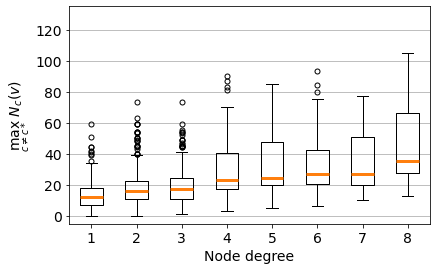

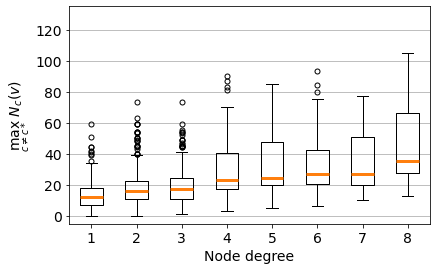

In [ ]:
plot_all(df, max_degree=8, type='max', plot_class=None, filter_dict={'dataset': 'citeseer','dense_split': True, 'lp_alpha': 0.7, 'model': 'GCN+LP', 'projection': True})

/tmp/ipykernel_1570204/1316425577.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(4*1.62, 4))


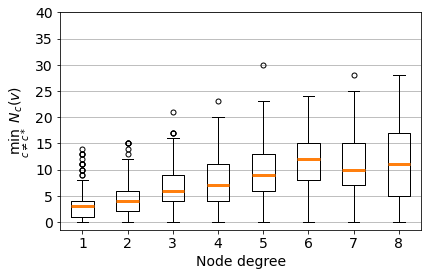

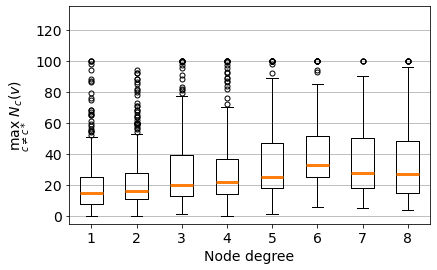

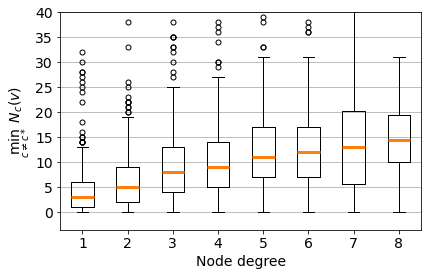

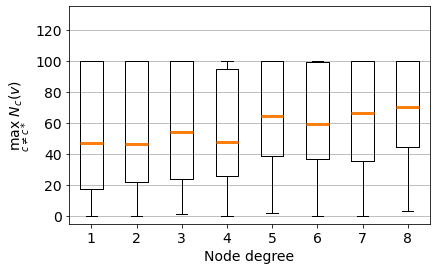

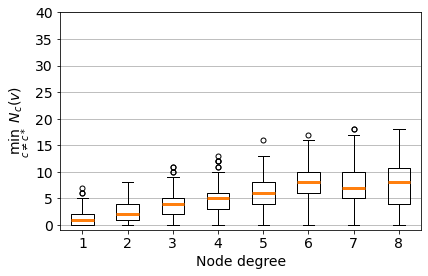

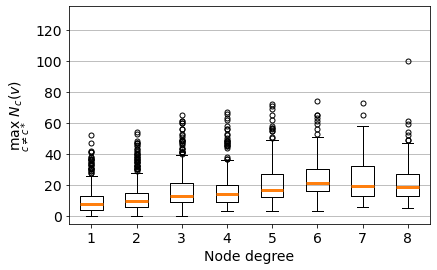

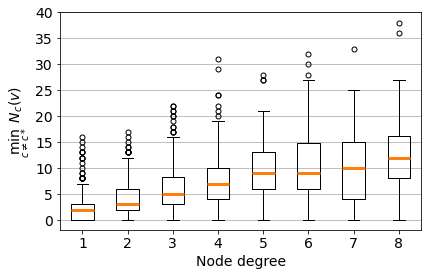

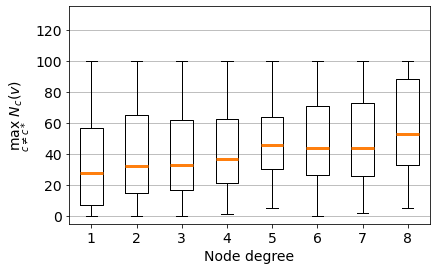

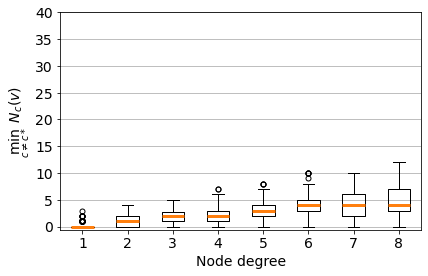

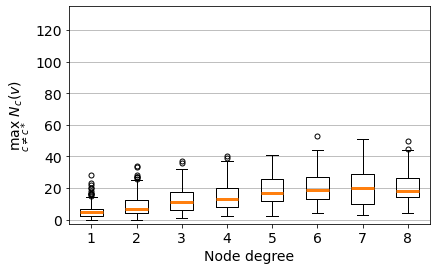

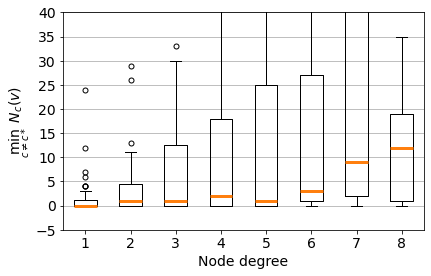

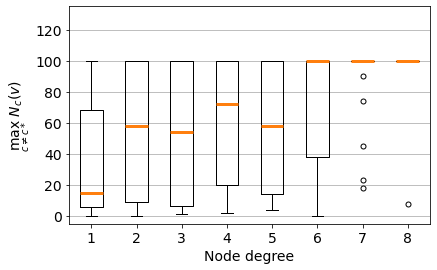

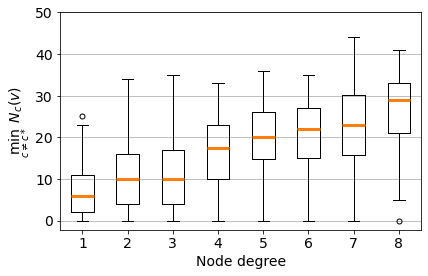

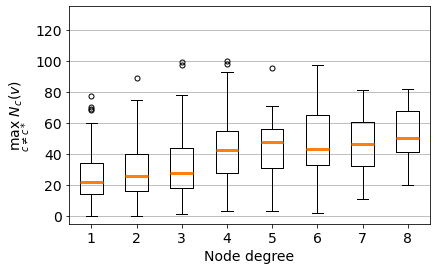

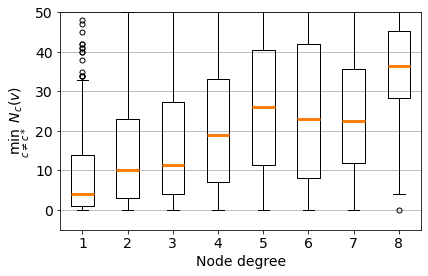

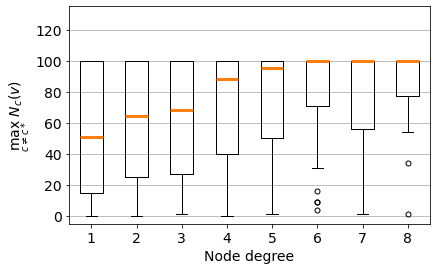

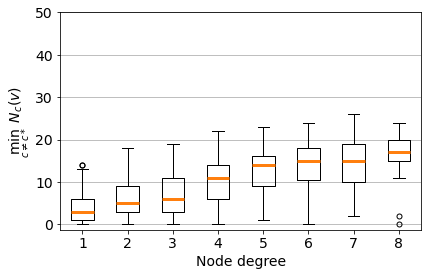

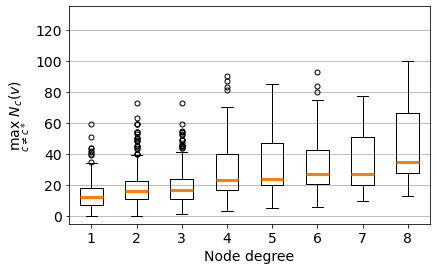

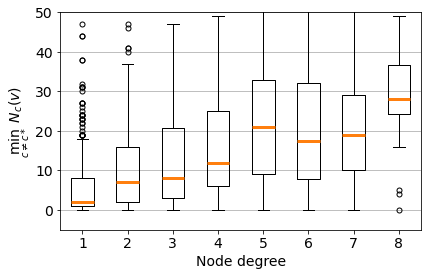

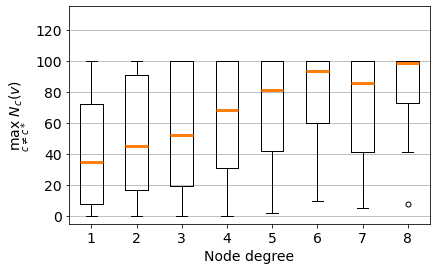

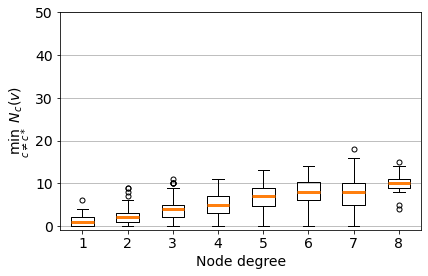

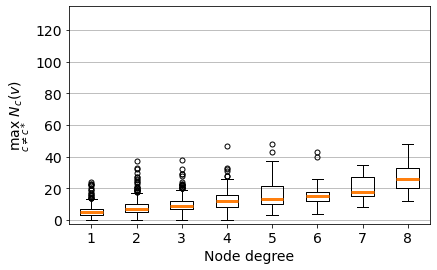

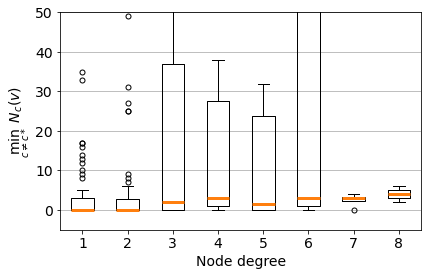

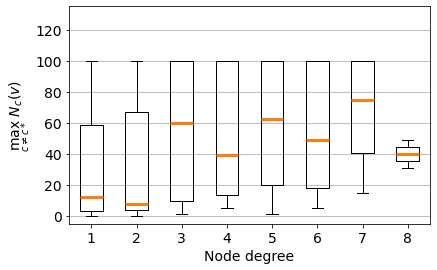

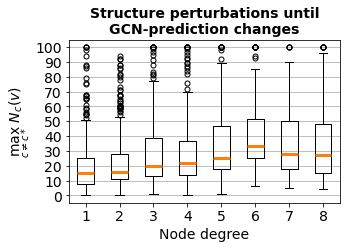

In [ ]:
# appendix plots
datasets = ['cora_ml', 'citeseer']
models = ['GCN', 'GCN+LP', 'LP']
types = ['min', 'max']
for dataset in datasets:
    for model in models:
        for split, split_name in [(True, 'dense_split'), (False, 'sparse_split')]:
            for plot_type in types:
                filter_dict = {'model': model, 'projection': True, 'dense_split': split, 'dataset': dataset}
                fig = plot_all(df, max_degree=8, type=plot_type, plot_class=None, filter_dict=filter_dict)
                fig.savefig(f'plots/{split_name}/{dataset}/boxplot_{model}_{plot_type}.pdf', bbox_inches='tight', format='pdf') 


# main plot
filter_dict = {'model': 'GCN', 'projection': True, 'dataset': 'cora_ml', 'dense_split': True}
fig = plot_all(df, max_degree=8, type='max', plot_class=None, filter_dict=filter_dict, main=True)
fig.savefig('plots/boxplot_main.pdf', bbox_inches='tight', format='pdf')

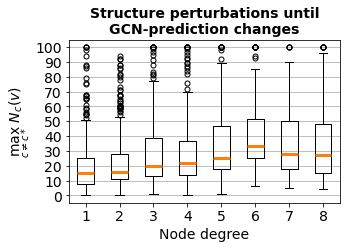

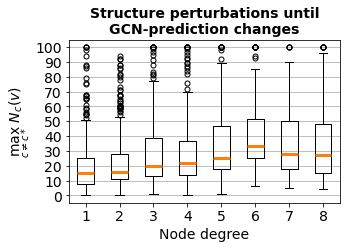

In [ ]:
# main plot
filter_dict = {'model': 'GCN', 'projection': True, 'dataset': 'cora_ml', 'dense_split': True}
fig = plot_all(df, max_degree=8, type='max', plot_class=None, filter_dict=filter_dict, main=True)
#fig.savefig('plots/boxplot_main.pdf', bbox_inches='tight', format='pdf')
fig